## DatasetとDataLoader

In [19]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from torch import optim
from sklearn import datasets
import torch.nn.functional as F
from torch.utils.data import Dataset

### dataset

In [2]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)

In [3]:
image, label = train_dataset[0]

In [4]:
image

In [5]:
label

5

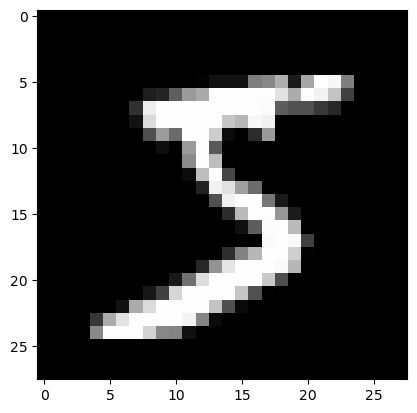

In [6]:
plt.imshow(image, cmap='gray')

In [7]:
len(train_dataset)

60000

### Transform

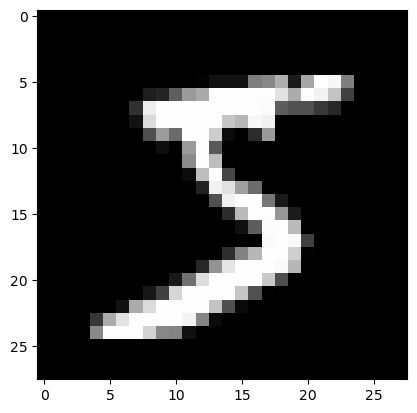

In [8]:
# .ToTensor
transform = torchvision.transforms.ToTensor()
image_tensor = transform(image)
plt.imshow(image_tensor[0], cmap='gray')

In [9]:
# .Normalization
normalize = torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))
normalized_image_tensor = normalize(image_tensor)
print(normalized_image_tensor.min(), normalized_image_tensor.max())

tensor(-1.) tensor(1.)


In [10]:
# .Compose
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))])
transformed_image = transform(image)

In [11]:
# データダウンロード時に変換
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
image, label = train_dataset[0]
image

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

### dataloader

In [12]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=2)

In [14]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

torch.Size([10, 1, 28, 28]) torch.Size([10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


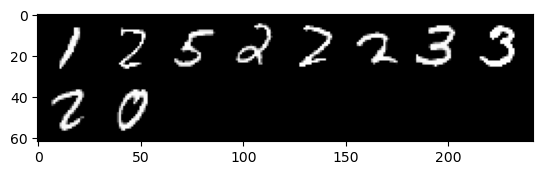

In [15]:
grid_images = torchvision.utils.make_grid(images)
plt.imshow(torch.permute(grid_images, (1, 2, 0)))

### dataloaderを学習で使用する

In [16]:
batch_size = 32

In [17]:
class MLP(nn.Module):
    def __init__(self, num_in, num_hidden, num_output):
        super().__init__()
        self.flatten = nn.Flatten()   # [b, c, h, w] -> [b, c*h*w]
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_output)

    def forward(self, x):
        x = self.flatten(x)
        z1 = self.l1(x)
        a1 = F.relu(z1)
        x = self.l2(a1)
        return x

learning_rate = 0.01
epochs = 5

# モデルの定義
model = MLP(28*28, 30, 10)

opt = optim.SGD(model.parameters(), lr=0.01)

# ログ
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):

    running_loss = 0.0
    running_val_loss = 0.0
    running_val_acc = 0.0


    for train_batch, data in enumerate(train_loader):

        X, y = data
        opt.zero_grad()

        # forward
        preds = model(X)
        loss = F.cross_entropy(preds, y)
        running_loss += loss.item()

        # backward
        loss.backward()

        # パラメータ更新
        opt.step()

    # validation
    with torch.no_grad():
        for val_batch, data in enumerate(val_loader):
            X_val, y_val = data
            preds_val = model(X_val)
            val_loss = F.cross_entropy(preds_val, y_val)
            running_val_loss += val_loss.item()
            val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]
            running_val_acc += val_accuracy.item()

    train_losses.append(running_loss/(train_batch + 1))
    val_losses.append(running_val_loss/(val_batch + 1))
    val_accuracies.append(running_val_acc/(val_batch + 1))

    
    # 損失ログ出力
    print(f'epoch: {epoch+1}: train_loss:{train_losses[-1]}, val_loss:{running_val_loss/(val_batch + 1)}, val_acuraccy:{running_val_acc/(val_batch + 1)}')

epoch: 1: train_loss:0.41672614634941174, val_loss:0.2717755493607838, val_acuraccy:0.921099993109703
epoch: 2: train_loss:0.2495881750015542, val_loss:0.2109899865433108, val_acuraccy:0.9376999935507775
epoch: 3: train_loss:0.19838927196439665, val_loss:0.17889925078162924, val_acuraccy:0.9462999938130379
epoch: 4: train_loss:0.17121003107908958, val_loss:0.17353395125601673, val_acuraccy:0.9485999938845634
epoch: 5: train_loss:0.15342691139819606, val_loss:0.14202684122277423, val_acuraccy:0.9556999938488007


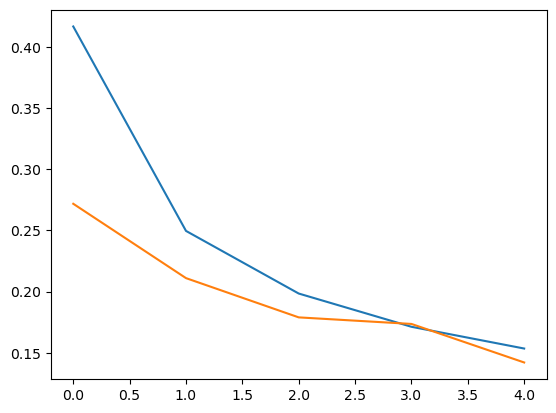

In [18]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')

### カスタムのDatasetの作成

In [20]:
class MYDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        return X, y

In [21]:
dataset = datasets.load_digits()
target = dataset['target']
images = dataset['images']
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

In [23]:
train_mydataset = MYDataset(X_train, y_train, transform=transform)
train_mydataset[0]

(tensor([[[-1., -1.,  5., 27.,  1., -1., -1., -1.],
          [-1., -1., 23., 23., -1., -1., -1., -1.],
          [-1.,  5., 31., 11., -1., -1., -1., -1.],
          [-1.,  9., 31.,  3., -1., -1., -1., -1.],
          [-1., 11., 31.,  3.,  9.,  3., -1., -1.],
          [-1.,  7., 31.,  3., 23., 29.,  3., -1.],
          [-1.,  1., 27., 25.,  3., 25., 21., -1.],
          [-1., -1.,  5., 21., 31., 25.,  7., -1.]]], dtype=torch.float64),
 6)